<a href="https://colab.research.google.com/github/numoworld/learnpytorchio/blob/main/06transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

torch.__version__, torchvision.__version__

('1.13.1+cu116', '0.14.1+cu116')

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import engine, data_setup
except:
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import engine, data_setup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3435, done.
remote: Total 3435 (delta 0), reused 0 (delta 0), pack-reused 3435
Receiving objects: 100% (3435/3435), 641.56 MiB | 43.50 MiB/s, done.
Resolving deltas: 100% (1975/1975), done.
Updating files: 100% (222/222), done.


In [3]:
!ls

going_modular  sample_data


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
import os
import requests
import zipfile

from pathlib import Path

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if not image_path.is_dir():
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(response.content)

with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zf:
  zf.extractall(image_path)

os.remove(data_path / 'pizza_steak_sushi.zip')

In [6]:
!ls data

pizza_steak_sushi


In [7]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [8]:
manual_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
train_dl, test_dl, classnames = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=32
)

classnames

['pizza', 'steak', 'sushi']

In [10]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [13]:
for param in model.parameters():
  param.requires_grad = False  # freezing parameters

In [14]:
torch.manual_seed(721)
torch.cuda.manual_seed(721)

out_shape = len(classnames)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(
        in_features=1280, 
        out_features=out_shape,
        bias=True)
).to(device)

In [15]:
summary(
    model=model,
    input_size=[32,3,224,224],
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [17]:
torch.manual_seed(721)
torch.cuda.manual_seed(721)

from timeit import default_timer as timer

start_time = timer()

results = engine.train(
    model=model,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=5,
    device=device
)

elapsed = timer() - start_time

print(f'Training time: {elapsed}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0730 | train_acc: 0.3516 | test_loss: 0.8870 | test_acc: 0.7017
Epoch: 2 | train_loss: 0.9164 | train_acc: 0.6172 | test_loss: 0.7382 | test_acc: 0.8447
Epoch: 3 | train_loss: 0.7463 | train_acc: 0.8711 | test_loss: 0.7398 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7526 | train_acc: 0.7070 | test_loss: 0.7182 | test_acc: 0.8049
Epoch: 5 | train_loss: 0.6915 | train_acc: 0.7656 | test_loss: 0.6429 | test_acc: 0.8561
Training time: 11.896043851000002


[INFO] Couldn't find helper_functions.py, downloading...


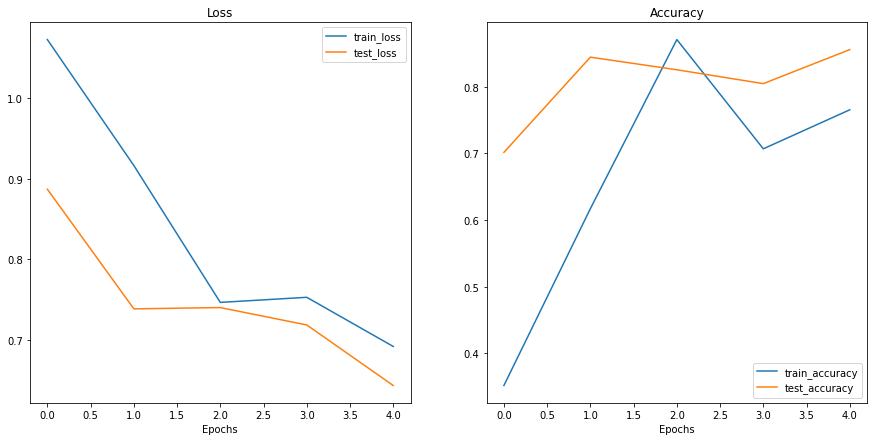

In [18]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)